# CS 505 Homework 04:  Classification

#### Due Friday  10/27 at midnight (1 minute after 11:59 pm) in Gradescope (with a grace period of 6 hours)
#### You may submit the homework up to 24 hours late (with the same grace period) for a penalty of 10%. 

All homeworks will be scored with a maximum of 100 points; point values are given
for individual problems, and if parts of problems do not have point values given, they
will be counted equally toward the total for that problem. 

Note: I strongly recommend you work in **Google Colab** (the free version) to complete homeworks in this class; in addition to (probably) being faster than your laptop, all the necessary libraries will already be available to you, and you don't have to hassle with <code>conda</code>, <code>pip</code>, etc. and resolving problems when the install doesn't work. But it is up to you!   You should go through the necessary tutorials listed on the web site concerning Colab and storing files on a Google Drive. And of course, Dr. Google is always ready to help you resolve your problems. 

I will post a  "walk-through" video ASAP on my <a href="https://www.youtube.com/channel/UCfSqNB0yh99yuG4p4nzjPOA">Youtube Channel</a>. 

#### Submission Instructions

You must complete the homework by editing <b>this notebook</b> and submitting the following two files in Gradescope by the due date and time:

  - A file <code>HW04.ipynb</code> (be sure to select <code>Kernel -> Restart and Run All</code> before you submit, to make sure everything works); and
  - A file <code>HW04.pdf</code> created from the previous.
  
  For best results obtaining a clean PDF file on the Mac, select <code>File -> Print Review</code> from the Jupyter window, then choose <code>File-> Print</code> in your browser and then <code>Save as PDF</code>.  Something  similar should be possible on a Windows machine -- just make sure it is readable and no cell contents have been cut off. Make it easy to grade!
  
The date and time of your submission is the last file you submitted, so if your IPYNB file is submitted on time, but your PDF is late, then your submission is late. 

## Collaborators (5 pts)

Describe briefly but precisely

1. Any persons you discussed this homework with and the nature of the discussion;
2. Any online resources you consulted and what information you got from those resources; and
3. Any AI agents (such as chatGPT or CoPilot) or other applications you used to complete the homework, and the nature of the help you received. 

A few brief sentences is all that I am looking for here. 

    <Your answer here>

In [2]:
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

from torchvision.datasets import MNIST
import torchvision.transforms as T

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import spacy



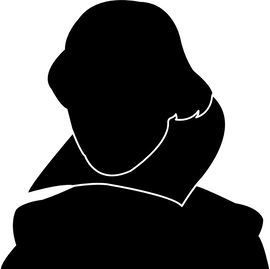

## Problem One: Exploring Shakespeare's Plays with PCA (45 pts)

In this problem, we will use Principal Components Analysis to look at Shakespeare's plays, as
we discussed with a very different play/movie in lecture.  Along the way, we shall use the tokenizer and the TF-IDF vectorizer from `sklearn,`
a common machine learning library.

Note: There is a library for text analysis in Pytorch called `Torchtext`, however, in my view this will less well-developed and less well-supported than the rest of Pytorch, so we shall use `sklearn` for this problem. 

 

### Part A:  Reading and exploring the data (5 pts)

The cells below read in three files and convert them to `numpy` arrays (I prefer to work with the arrays rather than with `pandas` functions, but it is your choice).  

1. The file `shakespeare_plays.csv` contains lines from William Shakespeare’s plays. The second column of the file contains the name of
the play, the third the name of the player (or the indication `<Stage Direction>`, and the fourth
the line spoken: 

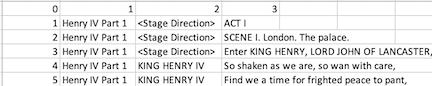


2. The file `play_attributes.csv` stores the genres and chronology of Shakepeare's plays; the first column is the name of the play, the second the genre, and the third its order in a chronological listing of when it was first performed. The plays are in the same (arbitrary) order as in the first file. 


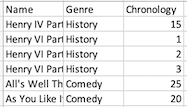


3. The file `player_genders.csv` stores the name of a major character (defined somewhat arbitrarily as one whose total lines contain more than 1400 characters) in the first column and their gender in the second. 



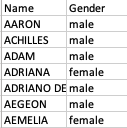

**To Do:**   For each of the arrays, print out the the `shape` and the first line. 


In [3]:
plays_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/shakespeare_plays.csv')

player_genders_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/player_genders.csv')

play_attributes_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/play_attributes.csv')

In [4]:
plays_array.head()

,0,1,2,3
0,1,Henry IV Part 1,<Stage Direction>,ACT I
1,2,Henry IV Part 1,<Stage Direction>,SCENE I. London. The palace.
2,3,Henry IV Part 1,<Stage Direction>,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV Part 1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV Part 1,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [5]:
player_genders_array.head()

,Name,Gender
0,AARON,male
1,ACHILLES,male
2,ADAM,male
3,ADRIANA,female
4,ADRIANO DE ARMADO,male


In [6]:
play_attributes_array.head()

,Name,Genre,Chronology
0,Henry IV Part 1,History,15
1,Henry VI Part 1,History,1
2,Henry VI Part 2,History,2
3,Henry VI Part 3,History,3
4,All's Well That Ends Well,Comedy,25


In [7]:
plays_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/shakespeare_plays.csv').to_numpy()

player_genders_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/player_genders.csv').to_numpy()

play_attributes_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/play_attributes.csv').to_numpy()


In [8]:
plays_array[0]

array([1, 'Henry IV Part 1', '<Stage Direction>', 'ACT I'], dtype=object)

In [9]:
player_genders_array[0]

array(['AARON', 'male'], dtype=object)

In [10]:
play_attributes_array[0]

array(['Henry IV Part 1', 'History', 15], dtype=object)

In [11]:
plays_array.shape

(111582, 4)

In [12]:
print(plays_array[0])

[1 'Henry IV Part 1' '<Stage Direction>' 'ACT I']


In [13]:
player_genders_array.shape

(398, 2)

In [14]:
print(player_genders_array[0])

['AARON' 'male']


In [15]:
play_attributes_array.shape

(36, 3)

In [16]:
print(play_attributes_array[0])

['Henry IV Part 1' 'History' 15]


### Part B: Visualizing the Plays (8 pts)

1. Create an array containing 36 strings, each being the concatenation of all lines spoken.   Be sure to NOT include stage directions!  You may wish to create an appropriate dictionary as an intermediate step. 

2. Create a document-term matrix where each row represents a play and each column represents a term used in that play. Each entry in this matrix represents the number of times a particular word (defined by the column) occurs in a particular play (defined by the row). Use `CountVectorizer` in `sklearn` to create the matrix. Keep the rows in the same order as in the original files in order to associate play names with terms correctly. 

3. From this matrix, use `TruncatedSVD` in `sklearn` to create a 2-dimensional representation of each play. Try to make it as similar as possible to the illustration below, including (i) appropriate title, (ii) names of each play, followed by its chronological order, and (iii) different colors for each genre. Use a `figsize` of `(8,8)` and a `fontsize` of `6` to provide the best visibility. You can follow the tutorial [here](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/) to create the visualization (look at the "PCA" part).

4. Now do the same thing all over again, but with TF-IDF counts (using `TFIDFVectorizer` in `sklearn`). 


5. Answer the following in a few sentences:  What plays are similar to each other? Do they match the grouping of Shakespeare’s plays into comedies, histories, and tragedies here?  Which plays are outliers (separated from the others in the same genre)?  Did one of TF or TF-IDF provided the best insights?


In [17]:
combined_lines = defaultdict(str)
for play in plays_array:
    title = play[1]
    actor = play[2]
    line = play[3]
    if not re.match(r"^<.*>$", play[-2]):
        combined_lines[title] += line

In [18]:
lines= []
for i in range(len(play_attributes_array)):
    play_name = play_attributes_array[i][0]
    lines.append(combined_lines[play_name])


In [19]:
print("The total number of plays is", len(lines))

The total number of plays is 36


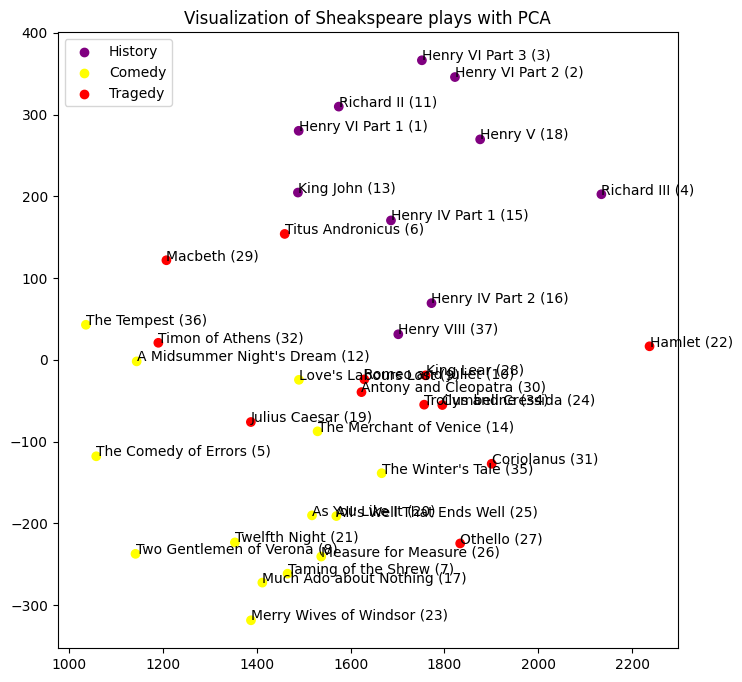

In [20]:


vectorizer = CountVectorizer()
pca = TruncatedSVD(n_components=2)
count_matrix = vectorizer.fit_transform(lines)
result = pca.fit_transform(count_matrix)


# Plot the data with TruncatedSVD
color_mapping = {
    'History': 'Purple',
    'Comedy': 'Yellow',
    'Tragedy': 'Red'
}

dict = defaultdict(lambda: '')

for row in play_attributes_array:
    dict[row[0]] = row
colors = []
scatter_names = []

for play in list(combined_lines.keys()):
    colors.append(color_mapping[dict[play][1]])
    name = play + " ("+str(dict[play][-1])+")"
    scatter_names.append(name)
    
plt.figure(figsize=(8, 8))

plt.title("Visualization of Sheakspeare plays with PCA")


for genre, color in color_mapping.items():
    plt.scatter([], [], label=genre, c=color)
plt.legend(loc='upper left')
plt.scatter(result[:, 0], result[:, 1], c=colors)


# Add a legend

for i, word in enumerate(scatter_names):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

In [21]:
# Convert lines to TF-IDF matrix
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(lines)
print(tfidf_matrix.shape)
#  plot the data with TruncatedSVD
tfidf_result = pca.fit_transform(tfidf_matrix)


(36, 46725)


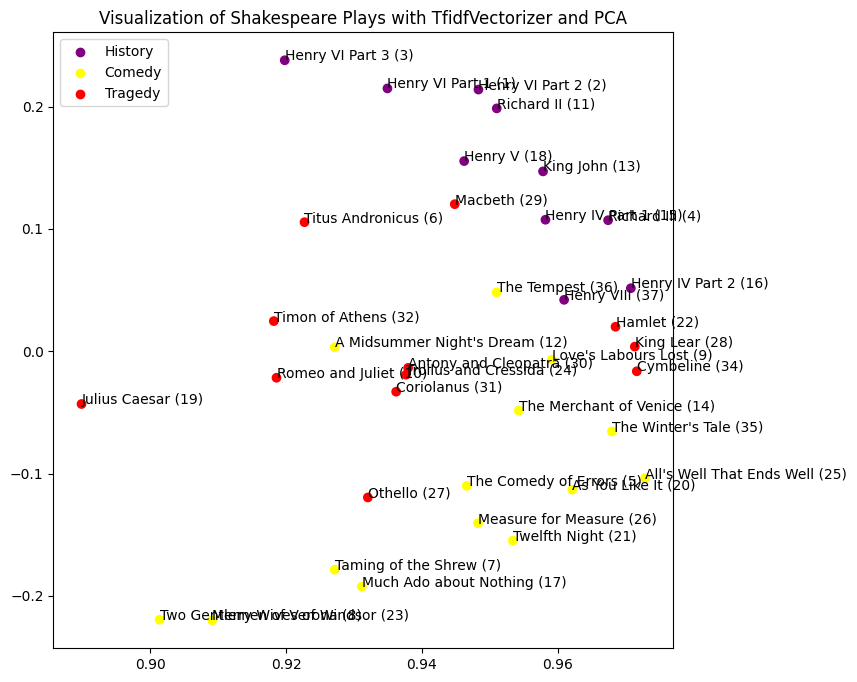

In [22]:
plt.figure(figsize=(8, 8))
plt.title("Visualization of Shakespeare Plays with TfidfVectorizer and PCA")
for genre, color in color_mapping.items():
    plt.scatter([], [], label=genre, c=color)
plt.legend(loc='upper left')
plt.scatter(tfidf_result[:, 0], tfidf_result[:, 1], c=colors)

for i, word in enumerate(scatter_names):
    plt.annotate(word, xy=(tfidf_result[i, 0], tfidf_result[i, 1]))

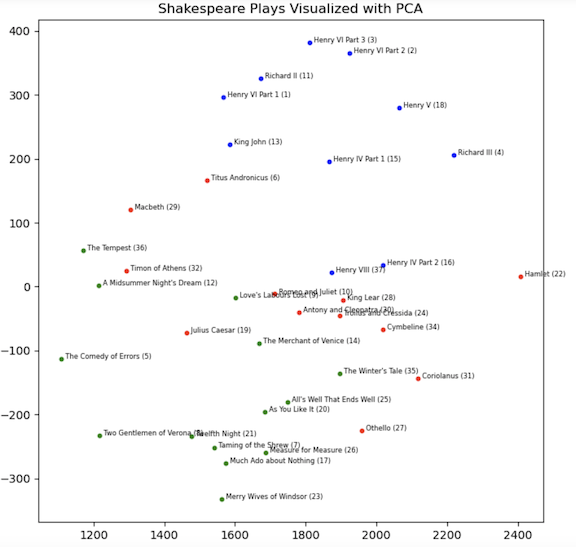

### Part C: Visualizing the Players (8 pts)

Now you must repeat this same kind of visualization, but instead of visualizing plays, you must visualize players.
The process will be essentially the same, starting with an array of strings representing the lines spoken by each player. Use one of TF or TF-IDF, and use different colors for the genders. 

Use a figsize of (8,8) and a fontsize of 4 to make this a bit more visible. 

Again, comment on what you observe (it will not be as satisfying as the previous part). 

In [23]:
#Create player gender dictionary
player_gender_map = {}
for player in player_genders_array:
    actor_name = player[0].lower()
    gender = player[1]
    player_gender_map[actor_name] = gender

In [24]:

# Map plays to their chronological order
play_order = {}
for play in play_attributes_array:
    play_name = play[0]
    year = str(play[2])
    play_order[play_name] = year

In [25]:
# Process and combine lines spoken by each actor
combined_lines_by_actor = defaultdict(str)
actor_gender_map = {}
for info in plays_array:
    title = info[1]
    actor_name = info[2]
    line = info[3]
    if not re.match(r"^<.*>$", actor_name) and actor_name.lower() in player_gender_map:
        actor_with_year = f"{actor_name} ({play_order[title]})"
        combined_lines_by_actor[actor_with_year] += line
        actor_gender_map[actor_with_year] = player_gender_map[actor_name.lower()]

In [26]:
# List of actors and their lines
actors_list = list(combined_lines_by_actor.keys())
lines_by_actor_list = list(combined_lines_by_actor.values())
genders_list = [actor_gender_map[actor] for actor in actors_list]
print("Total number of actors:", len(actors_list))

Total number of actors: 554


In [27]:

# Convert actor lines to a count matrix
vectorizer = CountVectorizer()
actor_matrix = vectorizer.fit_transform(lines_by_actor_list)

In [28]:
# Plot actors' data with TruncatedSVD
color_mapping_actors = {
    'male': 'Orange',
    'female': 'Pink',
}

In [29]:
player_result = pca.fit_transform(actor_matrix)

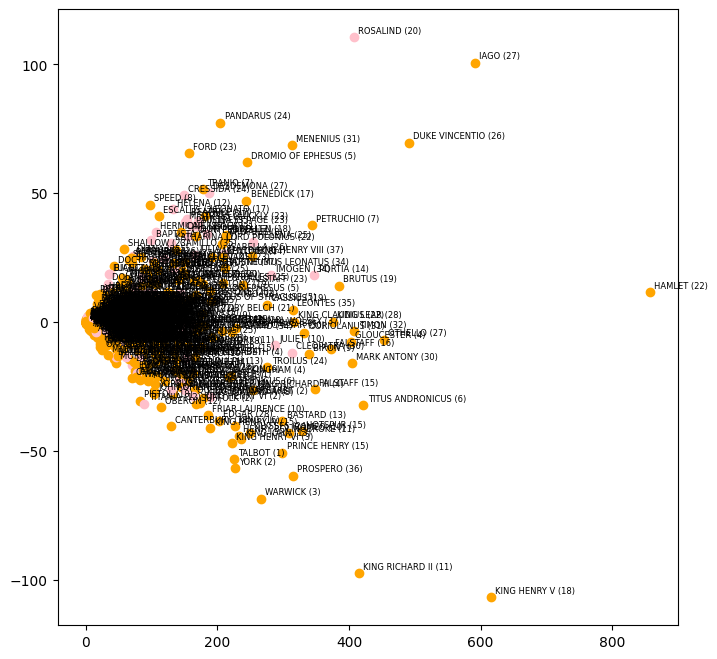

In [30]:
plt.figure(figsize=(8, 8))
for i in range(player_result.shape[0]):
    gender = genders_list[i]
    color = color_mapping_actors[gender]
    plt.scatter(player_result [i, 0], player_result[i, 1], color=color)
    actor_name = actors_list[i]
    label = f"{actor_name}"
    plt.annotate(label, (player_result[i, 0], player_result[i, 1]), fontsize=6, xytext=(3,3), textcoords="offset points")

plt.show()

### Part D:  DIY Word Embeddings (8 pts)

In this part you will create a word-word matrix where each row (and each column) represents a word in the vocabulary.
Each entry in this matrix represents the number of times a particular word (defined by the row) co-occurs with another
word (defined by the column) in a sentence (i.e., line in `plays`). Using the row word vectors, create a document-term matrix which represents
a play as the average of all the word vectors in the play. 

Display the plays using `TruncatedSVD` as you did previously.  Use one of TF or TF-IDF. 

Again, comment on what you observe: how different is this from the first visualization?

**Notes:**  

1. Remove punctuation marks .  ,  ;  :  ?  ! but leave single quotes. 
2. One way to proceed is to create a nested dictionary mapping each word to a dictionary of the frequency of words that occur in the same line, then from this to create the sparse matrix which is used to create the aerage document-term matrix which is input to `TruncatedSVD`. 
3. If you have trouble with the amount of memory necessary, you may wish to eliminate "stop words" and then isolate some number (say, 5000) of the remaining most common words, and build your visualization on that instead of the complete vocabulary. 


In [31]:
from gensim.models import Word2Vec

# Helper functions
def sanitize_line(line):
    return ''.join(ch.lower() for ch in line if ch not in ".,;:?!")

def add_to_wwm(tokens, wwm):
    for i, tok_i in enumerate(tokens):
        for j, tok_j in enumerate(tokens):
            if i != j:
                wwm[tok_i][tok_j] += 1

def document_vector(model, doc):
    doc = [word for word in doc if word in model.wv]
    return np.mean(model.wv[doc], axis=0) if len(doc) else np.zeros(model.vector_size)


In [32]:
#Sanitize and process plays
WWM = defaultdict(lambda: defaultdict(int))
sanitized_plays, unique_words, num_all_words = [], set(), 0

for _, play_name, actor, line in plays_array:
    if actor != '<Stage Direction>':
        sanitized_plays.append([play_name, sanitize_line(line)])

for _, line in tqdm(sanitized_plays):
    tokens = line.split()
    unique_words.update(tokens)
    num_all_words += len(tokens)
    add_to_wwm(tokens, WWM)


100%|██████████| 106475/106475 [00:03<00:00, 33887.85it/s]


In [33]:
# Matrix and mapping preparations
play_to_index, word_to_index = {}, {word: idx for idx, word in enumerate(unique_words)}
plays_word_matrix = np.zeros((36, len(unique_words)))
play_to_word_count = np.zeros(36)

for idx, (play, _, _) in enumerate(play_attributes_array):
    play_to_index[play] = idx

for play_name, line in tqdm(sanitized_plays):
    tokens = line.split()
    for word in tokens:
        plays_word_matrix[play_to_index[play_name]][word_to_index[word]] += 1
        play_to_word_count[play_to_index[play_name]] += 1

  0%|          | 0/106475 [00:00<?, ?it/s]

100%|██████████| 106475/106475 [00:00<00:00, 112517.06it/s]


In [34]:
# PCA for plays
part_d_pca = PCA(2)
result_part_d = part_d_pca.fit_transform(plays_word_matrix)

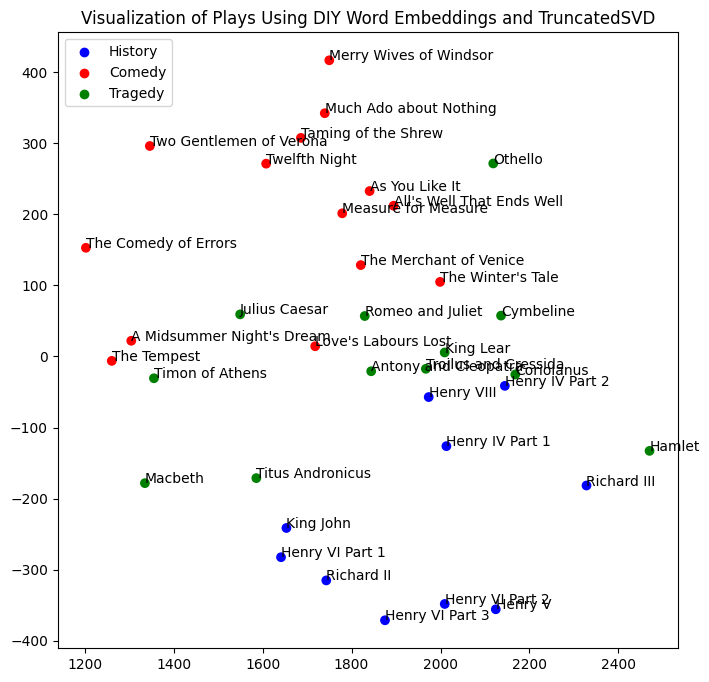

In [35]:
result = pca.fit_transform(plays_word_matrix)
names = list(dict.keys())

genre_dict = defaultdict(lambda: '')

color_mapping = {
    'History': 'blue',
    'Comedy': 'red',
    'Tragedy': 'green',
}

for row in play_attributes_array:
    genre_dict[row[0]] = row

colors = []
for play in names:
    colors.append(color_mapping[genre_dict[play][1]])
    
plt.figure(figsize=(8, 8))
plt.title("Visualization of Plays Using DIY Word Embeddings and TruncatedSVD")
for genre, color in color_mapping.items():
    plt.scatter([], [], label=genre, c=color)
plt.legend(loc='upper left')
plt.scatter(result[:, 0], result[:, 1], c=colors)


# Add a legend

for i, word in enumerate(names):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

### Part E:  Visualizing the Plays using Word2Vec Word Embeddings (8 pts)

Now we will do the play visualization using word embeddings created by Gensim's `Word2Vec`, which can create word embeddings just as you did in the previous part, but using better algorithms. 

You can read about how to use `Word2Vec` and get template code here:

https://radimrehurek.com/gensim/models/word2vec.html

I strongly recommend you follow the directions for creating the model, then using `KeyedVectors` to
avoid recomputing the model each time. 

Experiment with the `window` (say 5) and the `min_count` (try in the range 1 - 5) parameters to get the best results. 

Display the plays using `PCA` instead of `TruncatedSVD`.  Use one of TF or TF-IDF. 

Again, comment on what you observe: how different is this from the other visualizations?


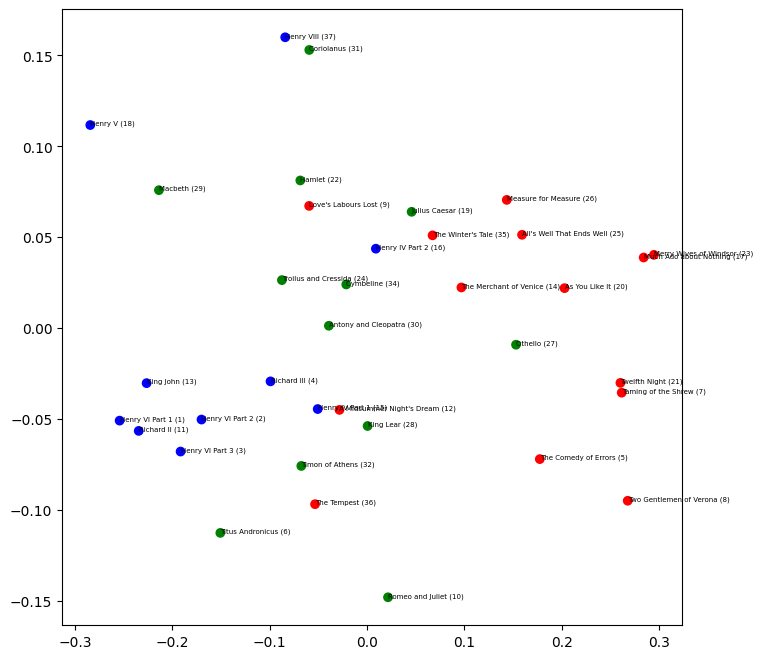

In [36]:
########
# Word2Vec models
tonkenized_play_lines = [sanitize_line(line).split() for line in lines]
model_e = Word2Vec(tonkenized_play_lines, vector_size=100, window=4, min_count=3, workers=4)

document_vectors_e = np.array([document_vector(model_e, doc) for doc in tonkenized_play_lines])
part_e_pca = PCA(2)
results_part_e = part_e_pca.fit_transform(document_vectors_e)

# Plot Word2Vec PCA results
plt.figure(figsize=(8, 8))
colors = []
for play in names:
    colors.append(color_mapping[genre_dict[play][1]])
plt.scatter(results_part_e[:, 0], results_part_e[:, 1], c=colors)

for i, (x, y) in enumerate(results_part_e):
    plt.annotate(f"{play_attributes_array[i][0]} ({play_attributes_array[i][2]})", (x, y), fontsize=5)

### Part F:  Visualizing the Players using Word2Vec Word Embeddings (8 pts)

Now you must repeat Part C, but using these `Word2Vec` embeddings. 

Use a figsize of (8,8) and a fontsize of 4 to make this a bit more visible. 

Again, comment on what you observe. How is this different from what you saw in Part C?


## Problem Two: Classifying Text with a Feed-Forward Neural Network (50 pts)


In this problem, you must create a FFNN in Pytorch to classify emails from the Enron dataset as to whether they
are spam or not spam ("ham"). For this problem, we will use `Glove` pretrained embeddings. The dataset
and the embeddings are in the following location:

https://drive.google.com/drive/folders/1cHR4VJuuN2tEpSkT3bOaGkOJrvIV-lSR?usp=sharing

(You can also download the embeddings yourself from the web; but the dataset is one created
just for this problem.)

### Part A: Prepare the Data (10 pts)

Compute the features of the emails (the vector of 100 floats input to the NN) vector based on the average value of the word vectors that belong to the words in it.

Just like the previous problem, we compute the 'representation' of each message, i.e. the vector, by averaging word vectors; but this time, we are using [Glove word embeddings](https://nlp.stanford.edu/projects/glove/) instead. Specifically, we are using word embedding 'glove.6B.100d' to obtain word vectors of each message, as long as the word is in the 'glove.6B.100d' embedding space.

Here are the steps to follow:

1. Have a [basic idea](https://nlp.stanford.edu/pubs/glove.pdf) of how Glove provides pre-trained word embeddings (vectors).
2. Download and extract word vectors from 'glove.6B.100d'. 
3. Tokenize the messages ( `spacy` is a good choice) and compute the message vectors by averaging the vectors of words in the message. You will need to test if a word is in the model (e.g., something like ` if str(word) in glove_model ...`) and ignore any words which have no embeddings. 


### Part B: Create the DataLoader (15 pts)

Now you must separate the data set into training, validation, and testing sets, and build a 'Dataset' and 'DataLoader' for each that can feed data to train your model with Pytorch.

Use a train-validation-test split of 80%-10%-10%. You can experiment with different batch sizes, starting with 64. 



Hints:
1. Make sure `__init__` , `__len__` and `__getitem__` of the your defined dataset are implemented properly. In particular, the `__getitem__` should return the specified message vector and its label.
2. Don't compute the message vector when calling the `__getitem__` function, otherwise the training process will slow down A LOT. Calculate these in an array before creating the data loader in the next step. 
3. The data in the `.csv` is randomized, so you don't need to shuffle when doing the split. 

In [67]:
#useful imports

import numpy as np
from numpy.random import randint,rand,seed,normal,permutation
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

from torchvision.datasets import MNIST
import torchvision.transforms as T


from keras.datasets import mnist
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm

from scipy.special import softmax
import spacy
import pandas as pd

ModuleNotFoundError: No module named 'keras'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

[('queen', 0.7698540687561035)]


In [ ]:
# data_dir = 'https://drive.google.com/drive/folders/1stS7Uj-GAtJASlgUFxyz0JM58dnoTA8L?usp=drive_link'

In [ ]:
#from gensim.scripts.glove2word2vec import glove2word2vec
# glove_input_file = 'https://drive.google.com/file/d/18aLgOmWo7bFidz3cJES52m51CNGS0SoQ/view?usp=sharing'
# word2vec_output_file = 'glove.6B.100d.txt.word2vec'
# glove2word2vec(glove_input_file, word2vec_output_file)

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file ='/content/drive/My Drive/test/glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

In [ ]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

In [62]:
emails_raw = pd.read_csv('enron_spam_ham.csv').to_numpy()

In [ ]:
# file_path = '/content/drive/My Drive/test/message.txt'

# # Open and read the file
# with open(file_path, 'r') as file:
#     content = file.read()

# # Print the file content
# print(content)

In [63]:
emails_raw[0]

array([["Subject: sevil yamin  anne ,  vasant sent this information to norma . i shall fwd his message to you .  vince  - - - - - - - - - - - - - - - - - - - - - - forwarded by vince j kaminski / hou / ect on 04 / 10 / 2001  03 : 02 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -  stinson gibner  04 / 10 / 2001 02 : 57 pm  to : vince j kaminski / hou / ect @ ect  cc :  subject : sevil yamin  vince ,  do you want me to do this , or vasant ?  - - stinson  - - - - - - - - - - - - - - - - - - - - - - forwarded by stinson gibner / hou / ect on 04 / 10 / 2001  02 : 57 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -  from : anne labbe / enron @ enronxgate on 04 / 06 / 2001 09 : 57 am  to : stinson gibner / hou / ect @ ect  cc :  subject : sevil yamin  stinson ,  i am the new hr generalist for the research group because norma villarreal is  moving to business analysis and reporting . earlier this week , norma and i  met with vince , and he said that he was going to talk to yo

In [109]:
sp = spacy.load('en_core_web_sm')

In [65]:
text, label = emails )

Subject: sevil yamin  anne ,  vasant sent this information to norma . i shall fwd his message to you .  vince  - - - - - - - - - - - - - - - - - - - - - - forwarded by vince j kaminski / hou / ect on 04 / 10 / 2001  03 : 02 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -  stinson gibner  04 / 10 / 2001 02 : 57 pm  to : vince j kaminski / hou / ect @ ect  cc :  subject : sevil yamin  vince ,  do you want me to do this , or vasant ?  - - stinson  - - - - - - - - - - - - - - - - - - - - - - forwarded by stinson gibner / hou / ect on 04 / 10 / 2001  02 : 57 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -  from : anne labbe / enron @ enronxgate on 04 / 06 / 2001 09 : 57 am  to : stinson gibner / hou / ect @ ect  cc :  subject : sevil yamin  stinson ,  i am the new hr generalist for the research group because norma villarreal is  moving to business analysis and reporting . earlier this week , norma and i  met with vince , and he said that he was going to talk to you about w

In [66]:
for word in document:
    print(word)
    print(type(word))
    print(str(word))
    print(type(str(word)))
    break

subject
<class 'spacy.tokens.token.Token'>
subject
<class 'str'>


In [67]:
str(word)

'subject'

In [68]:
model[str(word)]

array([-0.098252 ,  0.053359 ,  0.3814   ,  0.25006  ,  0.37622  ,
        0.39795  , -0.42648  , -0.11512  , -0.062542 , -0.30872  ,
       -0.1126   ,  0.017485 ,  0.42269  , -0.05028  , -0.036123 ,
       -0.17231  ,  0.022046 ,  0.269    , -0.23359  ,  0.012059 ,
       -0.17243  , -0.204    , -0.0737   , -0.11341  ,  0.11035  ,
       -0.56162  ,  0.080746 , -0.36331  , -0.30045  , -0.12815  ,
       -0.45184  ,  0.012891 , -0.1789   , -0.44184  ,  0.093577 ,
        0.59694  ,  0.023494 , -0.4611   , -0.45794  ,  0.11821  ,
       -0.5165   , -0.11584  ,  0.083922 ,  0.016293 , -0.25888  ,
       -0.30356  ,  0.28238  , -0.031084 ,  0.045921 , -0.65211  ,
        0.98727  ,  0.023694 ,  0.22667  ,  0.75697  , -0.20568  ,
       -1.3769   ,  0.41452  , -0.54832  ,  1.5247   ,  0.16025  ,
        0.35099  ,  0.99004  , -0.32081  , -0.51617  ,  1.7852   ,
       -0.36472  ,  0.52039  , -0.0099243,  0.066323 ,  0.073432 ,
       -0.40247  ,  0.04315  ,  0.49818  ,  0.50381  , -0.3044

In [69]:
emails_raw.shape

(28138, 2)

In [70]:
emails_raw[0:2]

array([["Subject: sevil yamin  anne ,  vasant sent this information to norma . i shall fwd his message to you .  vince  - - - - - - - - - - - - - - - - - - - - - - forwarded by vince j kaminski / hou / ect on 04 / 10 / 2001  03 : 02 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -  stinson gibner  04 / 10 / 2001 02 : 57 pm  to : vince j kaminski / hou / ect @ ect  cc :  subject : sevil yamin  vince ,  do you want me to do this , or vasant ?  - - stinson  - - - - - - - - - - - - - - - - - - - - - - forwarded by stinson gibner / hou / ect on 04 / 10 / 2001  02 : 57 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -  from : anne labbe / enron @ enronxgate on 04 / 06 / 2001 09 : 57 am  to : stinson gibner / hou / ect @ ect  cc :  subject : sevil yamin  stinson ,  i am the new hr generalist for the research group because norma villarreal is  moving to business analysis and reporting . earlier this week , norma and i  met with vince , and he said that he was going to talk to yo

In [71]:
emails_embedded = np.array([])

In [57]:
document[0][1]

TypeError: 'spacy.tokens.token.Token' object is not subscriptable

In [74]:
# new_row = np.array([model[str(word)],label])

In [106]:
for email in tqdm(emails_raw):
    text, label = email
    print(text)
    break

  0%|          | 0/28138 [00:00<?, ?it/s]

Subject: sevil yamin  anne ,  vasant sent this information to norma . i shall fwd his message to you .  vince  - - - - - - - - - - - - - - - - - - - - - - forwarded by vince j kaminski / hou / ect on 04 / 10 / 2001  03 : 02 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -  stinson gibner  04 / 10 / 2001 02 : 57 pm  to : vince j kaminski / hou / ect @ ect  cc :  subject : sevil yamin  vince ,  do you want me to do this , or vasant ?  - - stinson  - - - - - - - - - - - - - - - - - - - - - - forwarded by stinson gibner / hou / ect on 04 / 10 / 2001  02 : 57 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -  from : anne labbe / enron @ enronxgate on 04 / 06 / 2001 09 : 57 am  to : stinson gibner / hou / ect @ ect  cc :  subject : sevil yamin  stinson ,  i am the new hr generalist for the research group because norma villarreal is  moving to business analysis and reporting . earlier this week , norma and i  met with vince , and he said that he was going to talk to you about w

In [108]:
for email in tqdm(emails_raw):
    text, label = email
    # print(text)
    document = sp(text.lower())
    # print(document)
    words_in_doc = 0 
    for word in document:
        # print(word)
        # print(type(word))
        # print(str(word))
        # print(type(str(word)))
        # print(model[str(word)])

        if str(word)in model:
            words_in_doc+=1
            word_embedding = model[str(word)]
            doc_embedding = torch.zeros(100)
            # print(doc_embedding)
            # print(type(word_embedding))
            # print(word_embedding)
            torch_word_embedding = torch.from_numpy(word_embedding)
            # print(torch_word_embedding)
            # print(torch_word)
            # print(type(torch_word))
            # print(doc_embedding.shape)
            # print(torch_word_embedding.shape)
            doc_embedding+=torch_word_embedding
            # print(doc_embedding)
            
        
        emails_embeddings = torch.ones(100)
        # print(example)
        # example = example/4
        # print(example)
        doc_embedding = doc_embedding/words_in_doc
        # print(doc_embedding)
        emails_embeddings = torch.stack((emails_embeddings, doc_embedding))
        # print(emails_embeddings)
        # print(emails_embeddings.shape)

   
    
    
    
    # break
# print(emails_embeddings)

  0%|          | 0/28138 [00:00<?, ?it/s]

100%|██████████| 28138/28138 [26:25<00:00, 17.75it/s]  


In [104]:
print(emails_embeddings[1:])

tensor([[-8.7278e-04, -6.3114e-04,  1.4818e-03, -2.2505e-03, -2.7662e-03,
         -1.1383e-03, -1.8826e-04, -1.1308e-03, -9.7202e-04, -1.2433e-03,
         -1.1529e-03, -3.3659e-04,  4.6917e-04,  1.4301e-03, -5.1013e-04,
         -9.9763e-04,  5.5028e-04,  2.6184e-03, -6.8202e-04,  1.3038e-03,
          2.2970e-03,  1.6111e-03,  1.7252e-04,  9.8487e-04,  6.1982e-04,
          5.9727e-04, -1.1484e-03, -1.5739e-03,  9.8068e-04, -8.3447e-04,
          2.0290e-03,  8.6313e-04, -1.1866e-03,  1.0449e-03, -1.8942e-04,
         -9.3341e-04, -6.8432e-04,  3.2227e-03, -5.4654e-04, -1.0136e-03,
          6.6114e-04, -1.1348e-04,  8.2192e-04,  1.0203e-04,  1.5709e-03,
         -4.9924e-04, -2.7813e-03, -5.1995e-04,  2.1088e-03, -1.2675e-03,
         -1.6539e-03,  1.0839e-03, -8.3146e-04,  3.6038e-03, -3.7538e-03,
         -6.0553e-03,  2.3609e-03,  5.5866e-04,  3.4902e-03,  8.1636e-05,
         -9.5985e-04,  1.8833e-03, -7.0912e-04, -2.2795e-03,  2.2457e-03,
          4.2101e-04,  1.4960e-03,  6.

In [105]:
print(emails_embeddings.shape)

torch.Size([2, 100])


In [ ]:
# Convert the numpy array to a torch tensor
torch_tensor = torch.from_numpy(np_array)

In [59]:
emails_embedded = np.append(emails_embedded ,new_row ,axis=0)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
for document in emails_raw.shape[0]:
    

### Part C:  Build the neural net model (25 pts)

Once the data is ready, we need to design and implement our neural network model.

The model does not need to be complicated. An example structure could be:

1. linear layer 100 x 15
2. ReLU activation layer
3. linear layer 15 x 2

But feel free to test out other possible combinations of linear layers & activation function and whether they make significant difference to the model performance later.

In order to perform "early stopping," you must keep track of the best validation score as you go through the epochs, and
save the best model generated so far; then use the model which existed when the validation score
was at a minimum to do the testing. (This could also be the model which is deployed, although we won't
worry about that.) Read about `torch.save(...)` and `torch.load(...)` to do this. 

Experiment with different batch sizes and optimizers and learning rates to get the best validation
score for the model you create with early stopping. (Try not to look *too hard* at the final accuracy!) Include your final performance charts (using `show_performance_curves`) when you submit. 

Conclude with a brief analysis (a couple of sentences is fine) relating what experiments you did,
and what choices of geometry, optimizer, learning rate, and batch size gave you the best results.
It should not be hard to get well above 90% accuracy on the final test. 